In [25]:
from redbaron import redbaron
redbaron.ipython_behavior = False

import numpy as np
import scipy.signal
import pandas as pd
from pyha import Sfix, simulate, hardware_sims_equal, sims_close
import os

# this ignores some 'log' warnings that would fail the unit tests as they include system path
import warnings
warnings.filterwarnings('ignore')


import matplotlib
# set 'interactive' to False and run 'Restart & Run all' before you commit this notebook, else you will get failed tests in CI.
# also consider running in virtualenv, tests may fail if, for example, matplotlib versions differ
interactive = True
if interactive:
    matplotlib.use('nbagg')
    from pylab import rcParams
    rcParams['figure.figsize'] = 9, 4
    %load_ext autoreload
    %autoreload 2
    
# use to disable GATE level simulations
os.environ["PYHA_SKIP_GATE"] = '1'
    
import matplotlib.pyplot as plt
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()
    
def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Design filter

<IPython.core.display.Javascript object>


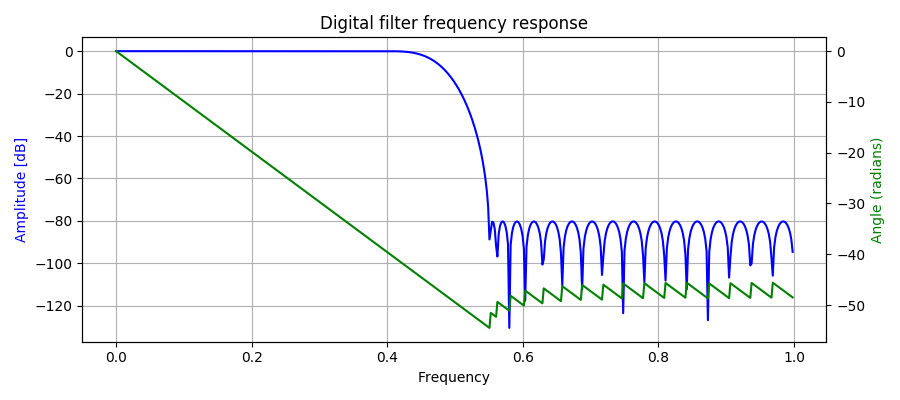

In [29]:
taps = scipy.signal.remez(64, [0, 0.4/2, 0.55/2, 1.0/2], [1, 0])
show_freqz(taps)

# Diagram

![alt text](diagram.png "Title")

# Pyha implementation

In [30]:
from pyha import Hardware, Complex
from pyhacores.filter import FIR

class BasebandFilter(Hardware):
    def __init__(self, taps):
        self.fir = [FIR(taps), FIR(taps)]

        # constants (written in CAPS)
        self.TAPS = taps
        self.DELAY = self.fir[0].DELAY

    def main(self, complex_in):
        """ Apply FIR filters to 'real' and 'imag' channels """
        real = self.fir[0].main(complex_in.real)
        imag = self.fir[1].main(complex_in.imag)
        return Complex(real, imag)

    def model_main(self, complex_in_list):
        """ Golden output """
        return scipy.signal.lfilter(self.TAPS, [1.0], complex_in_list)
    
dut = BasebandFilter(taps)

# Experiment 1: frequency response

In [4]:
inp = [0.0 + 0.0j] * 512
inp[0] = 1.0 + 1.0j

In [5]:
simulations = ['MODEL', 'PYHA', 'RTL', 'GATE']
#with Sfix._float_mode:
sims = simulate(dut, inp, simulations=simulations)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:sim:Running quartus map...will take time.
INFO:sim:Running netlist writer.
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Simulations completed!


In [6]:
pd.DataFrame(sims)

,GATE,MODEL,PYHA,RTL
0,(0.01000213623046875+0.01000213623046875j),(0.010006364783074888+0.010006364783074888j),(0.01000213623046875+0.01000213623046875j),(0.01000213623046875+0.01000213623046875j)
1,(0.00014495849609375+0.00014495849609375j),(0.00015077959888282994+0.00015077959888282994j),(0.00014495849609375+0.00014495849609375j),(0.00014495849609375+0.00014495849609375j)
2,0j,(6.129935818104901e-06+6.129935818104901e-06j),0j,0j
3,(-0.00032806396484375-0.00032806396484375j),(-0.0003294456202756435-0.0003294456202756435j),(-0.00032806396484375-0.00032806396484375j),(-0.00032806396484375-0.00032806396484375j)
4,(-9.1552734375e-05-9.1552734375e-05j),(-9.122428575445712e-05-9.122428575445712e-05j),(-9.1552734375e-05-9.1552734375e-05j),(-9.1552734375e-05-9.1552734375e-05j)
5,(0.000640869140625+0.000640869140625j),(0.000649794459654977+0.000649794459654977j),(0.000640869140625+0.000640869140625j),(0.000640869140625+0.000640869140625j)
6,(0.00030517578125+0.00030517578125j),(0.0003146812077024514+0.0003146812077024514j),(0.00030517578125+0.00030517578125j),(0.00030517578125+0.00030517578125j)
7,(-0.0011138916015625-0.0011138916015625j),(-0.0011150928067666826-0.0011150928067666826j),(-0.0011138916015625-0.0011138916015625j),(-0.0011138916015625-0.0011138916015625j)
8,(-0.0007781982421875-0.0007781982421875j),(-0.0007789200939893643-0.0007789200939893643j),(-0.0007781982421875-0.0007781982421875j),(-0.0007781982421875-0.0007781982421875j)
9,(0.001708984375+0.001708984375j),(0.0017188312008044417+0.0017188312008044417j),(0.001708984375+0.001708984375j),(0.001708984375+0.001708984375j)


In [7]:
assert hardware_sims_equal(sims)

INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!
INFO:sim:RTL OK!
INFO:sim:GATE OK!


In [8]:
assert sims_close(sims)

INFO:sim:sims_close(rtol=0.0001, atol=3.0517578125e-05)
INFO:sim:Using "MODEL" as golden output
INFO:sim:MODEL OK!
INFO:sim:PYHA OK!
INFO:sim:RTL OK!
INFO:sim:GATE OK!


<IPython.core.display.Javascript object>


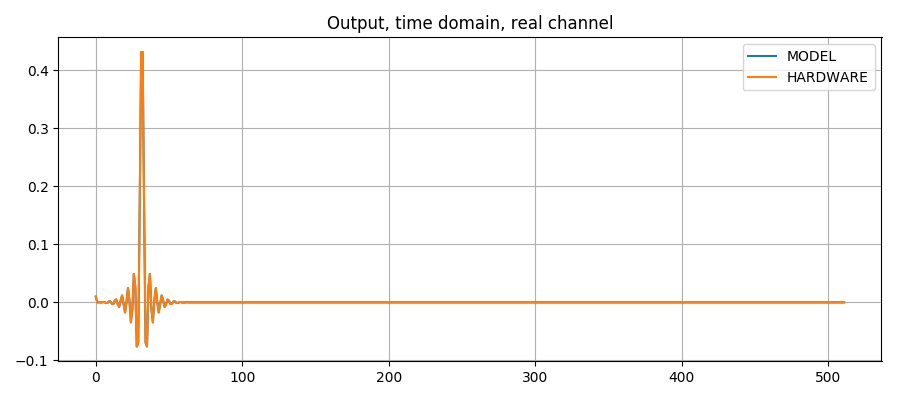

In [9]:
plt.title('Output, time domain, real channel')
plt.plot(np.array(sims['MODEL']).real, label='MODEL')
plt.plot(np.array(sims['PYHA']).real, label='HARDWARE')
show_plot()

<IPython.core.display.Javascript object>


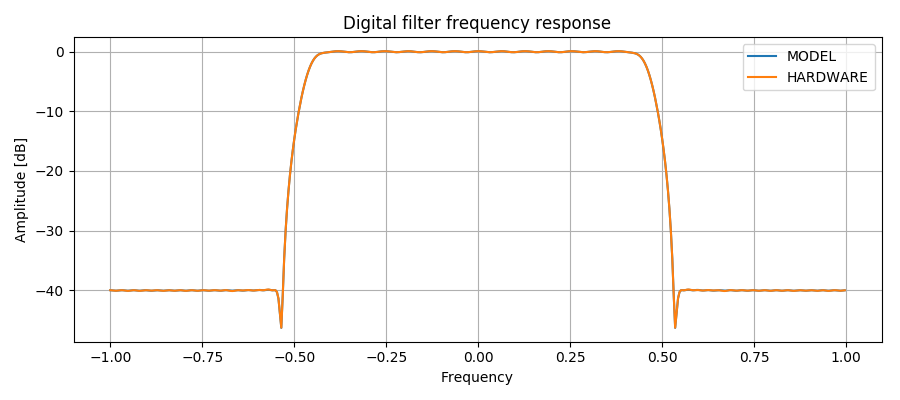

In [10]:
gain_fix = 512-128-22
plt.title('Digital filter frequency response')
plt.magnitude_spectrum(np.array(sims['MODEL']) * gain_fix, window=matplotlib.mlab.window_none, scale='dB', label='MODEL')
plt.magnitude_spectrum(np.array(sims['PYHA']) * gain_fix, window=matplotlib.mlab.window_none, scale='dB', label='HARDWARE')

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

# Experiment 2: filtering

<IPython.core.display.Javascript object>


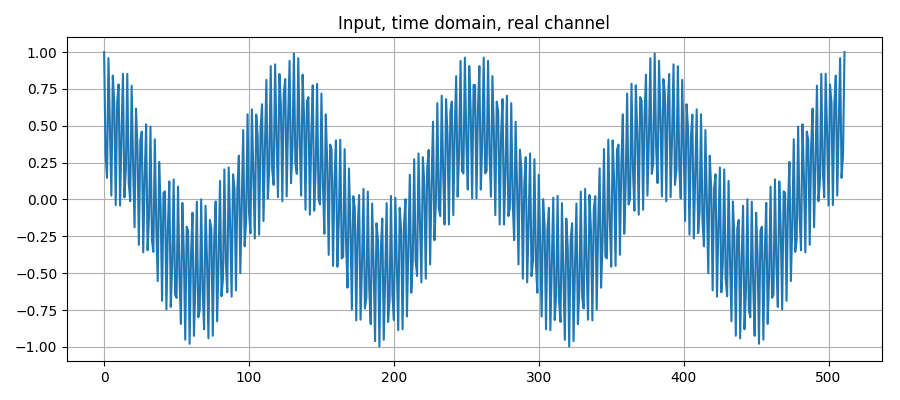

<IPython.core.display.Javascript object>


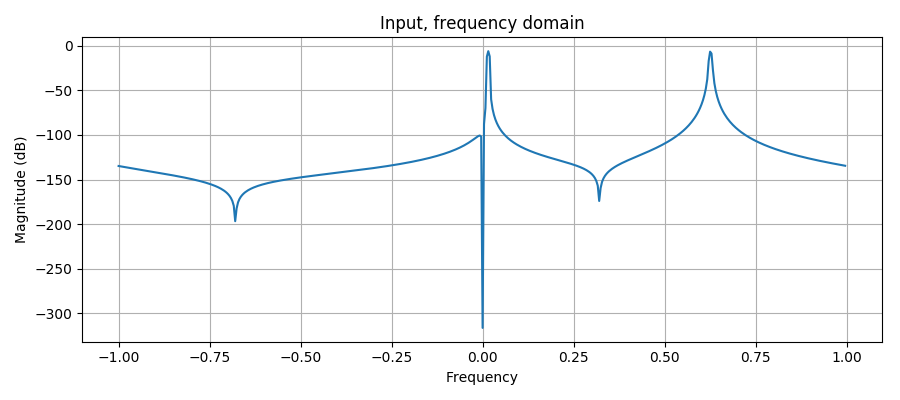

In [11]:
fs = 256
t = np.linspace(0, 2, 2*fs)
s0 = np.exp(2 * np.pi * 2 * t * 1j) * 0.5
s1 = np.exp(2 * np.pi * 80 * t * 1j) * 0.5
inp = s0 + s1

plt.title('Input, time domain, real channel')
plt.plot(inp.real)
show_plot()

plt.title('Input, frequency domain')
plt.magnitude_spectrum(inp, scale='dB')
show_plot()

In [12]:
sims = simulate(dut, inp, simulations=simulations)
assert hardware_sims_equal(sims)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:sim:Running quartus map...will take time.
INFO:sim:Running netlist writer.
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!
INFO:sim:RTL OK!
INFO:sim:GATE OK!


<IPython.core.display.Javascript object>


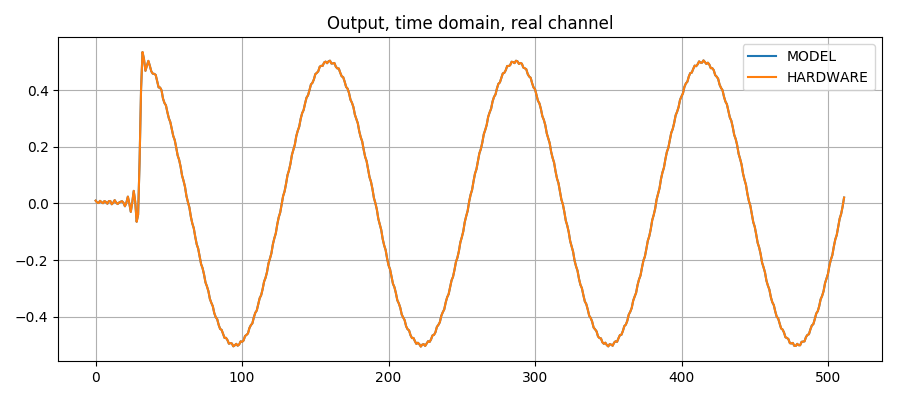

<IPython.core.display.Javascript object>


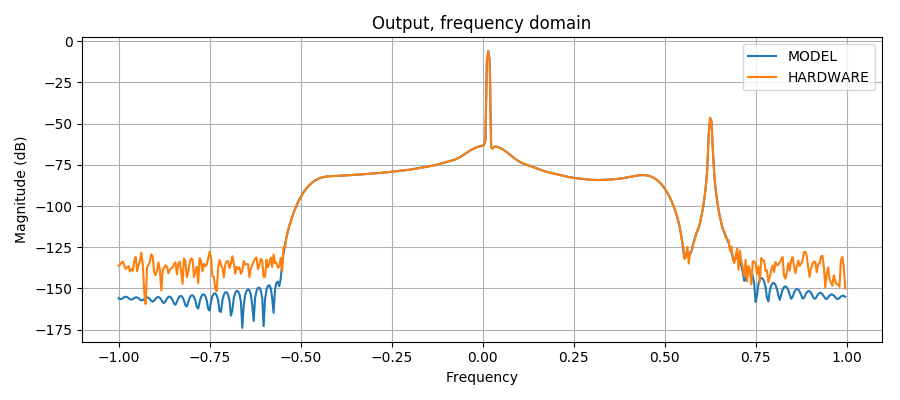

In [13]:
plt.title('Output, time domain, real channel')
plt.plot(np.array(sims['MODEL']).real, label='MODEL')
plt.plot(np.array(sims['PYHA']).real, label='HARDWARE')
show_plot()

plt.title('Output, frequency domain')
plt.magnitude_spectrum(sims['MODEL'], scale='dB', label='MODEL')
plt.magnitude_spectrum(sims['PYHA'], scale='dB', label='HARDWARE')
show_plot()

# Experiment 3: noise response

In [31]:
np.random.seed(0)  # reproduce tests
inp = np.random.uniform(-1, 1, 512) + np.random.uniform(-1, 1, 512)*1j
# inp *= 0.75


In [36]:
sims = simulate(dut, inp, simulations=simulations)
assert hardware_sims_equal(sims)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:sim:Simulations completed!
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!
INFO:sim:RTL OK!


<IPython.core.display.Javascript object>


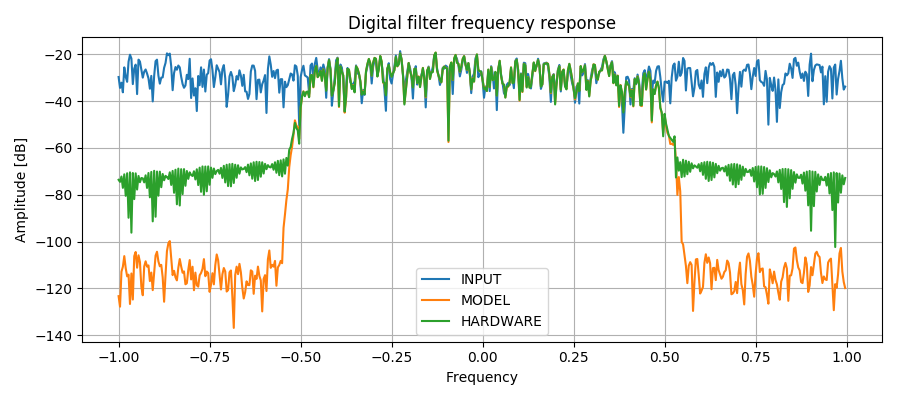

In [33]:
plt.title('Digital filter frequency response')
plt.magnitude_spectrum(inp, scale='dB', label='INPUT')
plt.magnitude_spectrum(sims['MODEL'], scale='dB', label='MODEL')
plt.magnitude_spectrum(sims['PYHA'], scale='dB', label='HARDWARE')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

<IPython.core.display.Javascript object>


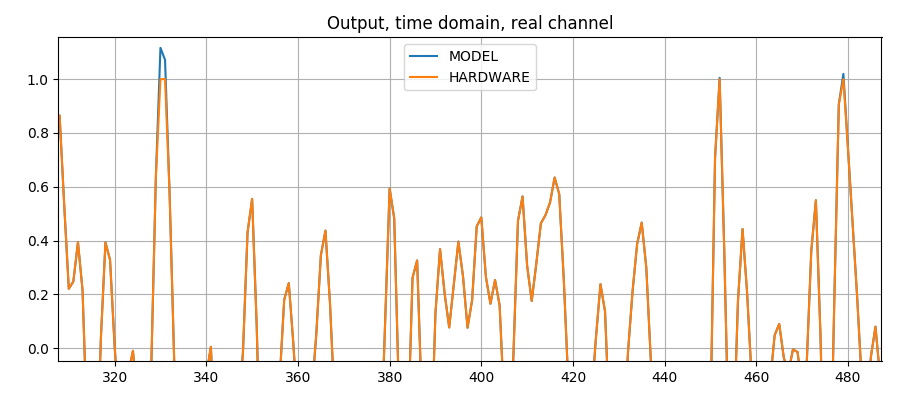

In [34]:
plt.title('Output, time domain, real channel')
plt.plot(np.array(sims['MODEL']).real, label='MODEL')
plt.plot(np.array(sims['PYHA']).real, label='HARDWARE')
show_plot()